<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Шкунов Павел Андреевич

**Забавный факт о себе:** После этой домашки я стал немного двунаправленным кодировщиком представлений трансформера

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
from google.colab import drive

from tqdm.notebook import tqdm
from pathlib import Path

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
import random
import os

def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [ ]:
import gdown

url = "https://drive.google.com/drive/folders/1M4iCa9FlDGhxB1sAKL5J4u_8wHCk-nW0?usp=sharing"

gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [ ]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [ ]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [ ]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-7-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [ ]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [ ]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [ ]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item, jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [ ]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [ ]:
df_ria.target_tags.values[:3]

array([list([622, 971, 226]), list([556, 660, 226]), list([648])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from nltk.tokenize import word_tokenize

def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [ ]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [ ]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [ ]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [ ]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [ ]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [ ]:
df_ria['snippet_clean'] = df_ria['snippet'].fillna('').apply(normalise_text)
df_vk['snippet_clean'] = df_vk['snippet'].fillna('').apply(normalise_text)

In [ ]:
df_ria['snippet_clean'] = df_ria['snippet_clean'].apply(lambda x: x if x else '#UNKN')
df_vk['snippet_clean'] = df_vk['snippet_clean'].apply(lambda x: x if x else '#UNKN')

In [ ]:
df_vk['title_clean'] = df_vk.title.apply(normalise_text)
df_vk

,id,href,datetime,title,likes,comments,snippet,snippet_clean,title_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,#UNKN,в днр заявили о задержании диверсантов причаст...
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,#UNKN,житель урала заминировал тц изза снятия сотов...
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,#UNKN,в черном море нашли потерянный флот гитлера
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,#UNKN,в сша освободили задержанную российскую актрис...
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,#UNKN,толкнувший скабееву депутат рады заявил о гроз...
...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,#UNKN,политологи назвали губернаторов которым грозит...
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,#UNKN,захарова рассказала какую книгу подписывал лав...
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,#UNKN,современные люди появились более 300 тысяч лет...
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,#UNKN,в сша ребенок устроил стрельбу


## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [ ]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [ ]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [ ]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [ ]:
df_test = df_ria[df_ria.date.str.contains('-12-')]
df_val = df_ria[df_ria.date.str.contains('-10-|-11-')]
df_train = df_ria[~df_ria.date.str.contains('-10-|-11-|-12-')]

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [ ]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1307, 460]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1438, 226]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[408, 884]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1551]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1509, 226]"


Напишем датасет для поставки данных в нейросеть.


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

        self.vocab = {word: idx  for word, idx in vocab.items() if idx < vocab_size}
        self.max_classes = max_classes
        self.y=self.target_ohe(target)
        self.X_title = self.create_text(title, max_title_len)
        if snippet is not None:
            self.X_snippet = self.create_text(snippet, max_snippet_len)
        else:
            self.X_snippet = None

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.X_snippet is not None:
            return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])
        return (self.X_title[idx, :], self.y[idx])


In [ ]:
!pip3 install pytorch_lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 17.9 MB/s eta 0:00:00


In [ ]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Внесите в код датасета выше свои правки

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=2)

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [ ]:
class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, text):
        result = self.model(text)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        *text, target = train_batch
        logits = self.model(*text)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )
        return loss

    def validation_step(self, val_batch, batch_idx):
        *text, target = val_batch
        logits = self.model(*text)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )
        return loss

Обучим модель.

In [ ]:
seed_everything(SEED)

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_baseline, LR, criterion)

wandb_logger = WandbLogger(log_model='all', project='hw_4')
trainer = pl.Trainer(max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


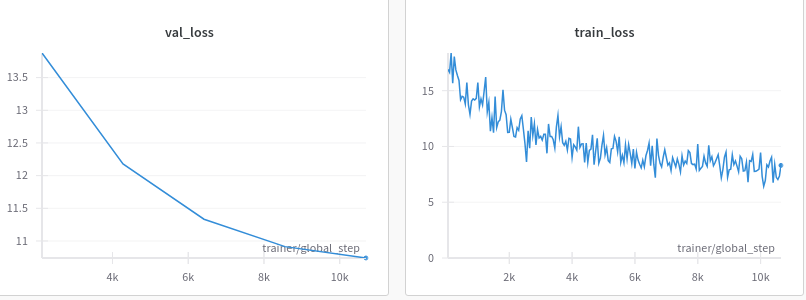

__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20
MAX_SNIPPET_LEN = 150

# словарь создаем по всей выборке
full_vocab = create_vocab(' '.join(df_ria.title_clean.values) + ' '.join(df_ria.snippet_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, full_vocab, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_SNIPPET_LEN)
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, full_vocab, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, MAX_SNIPPET_LEN)
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, full_vocab, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, MAX_SNIPPET_LEN)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=2)

In [ ]:
class ConcatClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        embedded_title = self.embedding(title)
        embedded_title = embedded_title.mean(dim=1)
        embedded_snippet = self.embedding(snippet)
        embedded_snippet = embedded_snippet.mean(dim=1)
        return self.fc(torch.cat((embedded_title, embedded_snippet), 1))

In [ ]:
seed_everything(SEED)

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_concat = ConcatClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_concat, LR, criterion)

wandb_logger = WandbLogger(log_model='all', project='hw_4')
trainer = pl.Trainer(max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ConcatClassifier | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


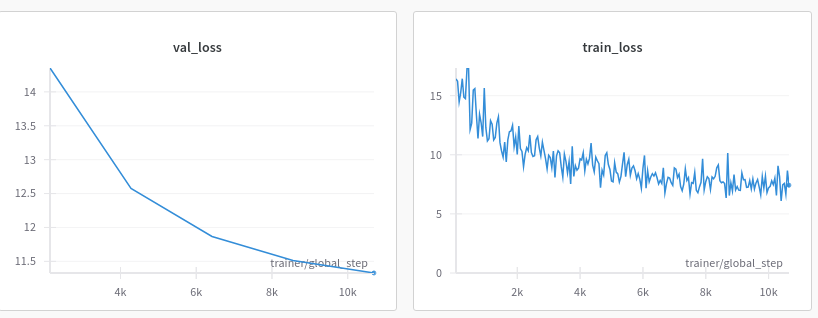

Ошибка модели со снипетами на валидационной выборке выше, чем у модели без снипетов

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.*(y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9954163432121277
Precision: 0.28692737221717834
Recall: 0.7649936676025391


In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983054399490356
Precision: 0.5117730498313904
Recall: 0.6154921054840088


In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.998320996761322
Precision: 0.005022480618208647
Recall: 0.004658704157918692


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset):

    dataloader = DataLoader(dataset, shuffle=False)

    pred_probs = torch.empty(len(dataset), CLASSES_NUM)
    targets = torch.empty(len(dataset), CLASSES_NUM)

    model.eval()
    with torch.no_grad():
        for iter, (*text, target) in tqdm(enumerate(dataloader), total=len(dataset)):
            logit = model(*text)
            pred_probs[iter, :] = F.softmax(logit, dim=1).squeeze()
            targets[iter, :] = target

    assert pred_probs.shape[0] == dataset.__len__()

    return pred_probs, targets

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__

Наверное, выбор метрики зависит от того, зачем мы решаем ту или иную задачу. Мне кажется, автоматическое определения тегов можно использовать чтобы пользователи могли, например, фильтровать новости по интересным им тегам. В таком случае важнее точность. Скорее всего, на сайте много новостей и ничего страшного, если пользователь пропустит какую-то из интересных. С другой стороны, пользователю будет неприятно потратить время на чтение новости из не интересной ему категории.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
def optimaize_precision(pred_prob, target, step=0.01):

    best_thresh, best_precision = 0, 0

    for t in tqdm(np.arange(0, 1, step)):
        y_pred = 1 * (pred_prob > t)
        pr = precision(target, y_pred)
        if pr > best_precision:
            best_thresh = t
            best_precision = pr

    return best_thresh

### Модель без снипетов

In [ ]:
pred_prob, target = get_predict(model_baseline, val_dataset)
TRESHOLD = optimaize_precision(pred_prob, target)

  0%|          | 0/43258 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
TRESHOLD

0.13

In [ ]:
pred_prob, target = get_predict(model_baseline, test_dataset)
y_pred = 1 * (pred_prob > TRESHOLD)
precision(target, y_pred)

  0%|          | 0/21304 [00:00<?, ?it/s]

0.5772081017494202

### Модель со снипетами

In [ ]:
pred_prob, target = get_predict(model_concat, val_dataset)

  0%|          | 0/43258 [00:00<?, ?it/s]

In [ ]:
TRESHOLD = optimaize_precision(pred_prob, target)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
TRESHOLD

0.11

In [ ]:
pred_prob, target = get_predict(model_concat, test_dataset)
y_pred = 1 * (pred_prob > TRESHOLD)
precision(target, y_pred)

  0%|          | 0/21304 [00:00<?, ?it/s]

0.4971148669719696

Модель без снипетов показывает лучшее качество на тестовой выборке.

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[922, 1538]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[1246, 750]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[1313, 1010]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1066]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[725, 750]"


In [ ]:
oob_dataset = NewsDataset(target=df_oob.target_tags.values,
                          title=df_oob.title_clean,
                          vocab=vocabulary,
                          vocab_size=VOCAB_SIZE,
                          max_title_len=MAX_TITLE_LEN,
                          max_classes=CLASSES_NUM)

In [ ]:
pred_prob, target = get_predict(model_baseline, oob_dataset)

  0%|          | 0/1133 [00:00<?, ?it/s]

In [ ]:
TRESHOLD = 0.13

In [ ]:
y_pred = 1 * (pred_prob > TRESHOLD)
precision(target, y_pred)

0.5377282500267029

На отложенной выборке качество проседает, но не сильно

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

#### Модель со сверточными слоями

__Ваш лог экспериментов:__

-
-
-

Экспериментировал с разным количеством фильтров и применением dropout. Во всех эксперментах используются фильтры на 2-gram (размер 2 * размерность эмбеддингов)

**модель без dropout, 50 фильтров**

https://wandb.ai/pvlshknv/hw_4/runs/6roo130f?workspace=user-pvlshknv

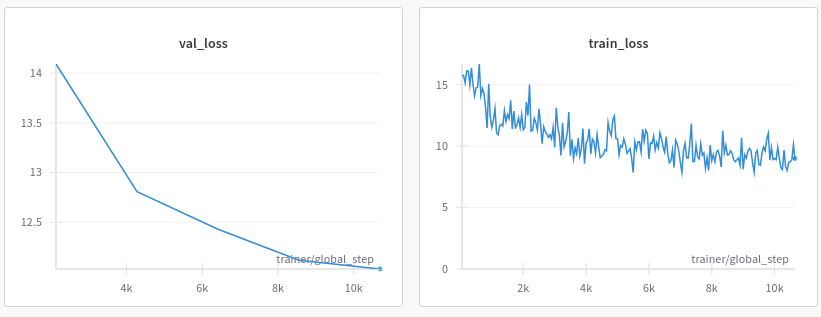

**модель с dropout p=0.3, 50 фильтров**

https://wandb.ai/pvlshknv/hw_4/runs/qwzqaicb?workspace=user-pvlshknv

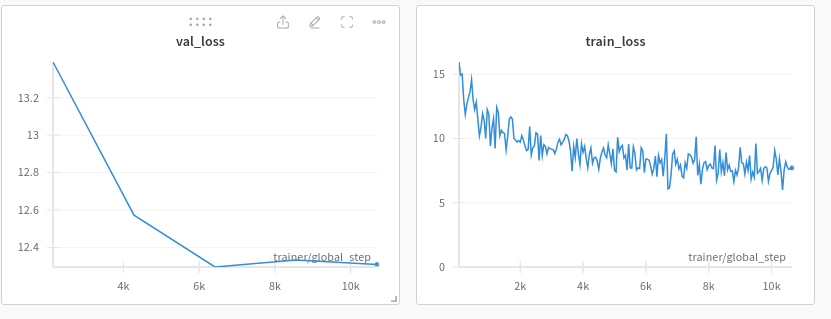

**модель с dropout p=0.5, 300 фильтров**

https://wandb.ai/pvlshknv/hw_4/runs/74itlowf?workspace=user-pvlshknv

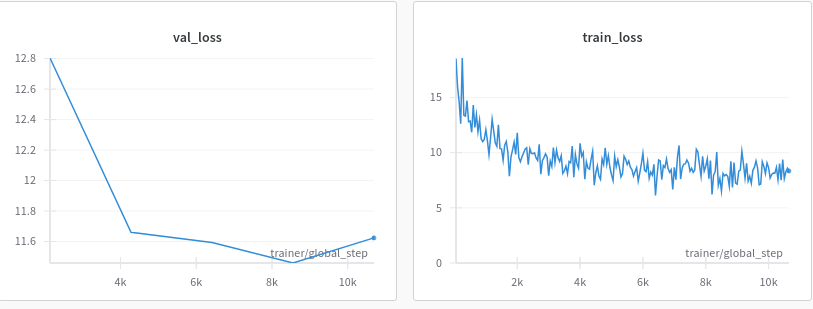

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20
MAX_SNIPPET_LEN = 200

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values) + ' '.join(df_ria.snippet_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_train.snippet_clean.values, MAX_SNIPPET_LEN)
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_val.snippet_clean.values, MAX_SNIPPET_LEN)
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, df_test.snippet_clean.values, MAX_SNIPPET_LEN)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=2)

In [ ]:
class ConvClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim, title_len, snippet_len, num_kernels, kernel_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(num_kernels, output_dim)
        self.conv = nn.Conv2d(1, num_kernels, (kernel_size, embedding_dim))
        self.max_pool = nn.MaxPool1d(title_len + snippet_len - kernel_size + 1, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, title, snippet):
        title_embed = self.embedding(title)
        snippet_embed = self.embedding(snippet)
        x = torch.cat((title_embed, snippet_embed), 1).unsqueeze(dim=1)
        x = self.conv(x).squeeze()
        x = self.max_pool(x).squeeze()
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
seed_everything(SEED)

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3
NGRAM = 2

model_concat = ConvClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM, MAX_TITLE_LEN, MAX_SNIPPET_LEN, 300, NGRAM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_concat, LR, criterion)


wandb_logger = WandbLogger(log_model='all', project='hw_4')
trainer = pl.Trainer(max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ConcatClassifier | 3.7 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.627    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


##### Подбор порога по валидационной выборке и оценка на тесте

In [ ]:
def get_predict(model, dataset):

    dataloader = DataLoader(dataset, shuffle=False)

    pred_probs = torch.empty(len(dataset), CLASSES_NUM)
    targets = torch.empty(len(dataset), CLASSES_NUM)

    model.eval()
    with torch.no_grad():
        for iter, (*text, target) in tqdm(enumerate(dataloader), total=len(dataset)):
            logit = model(*text)
            pred_probs[iter, :] = F.softmax(logit, dim=0).squeeze()
            targets[iter, :] = target

    assert pred_probs.shape[0] == dataset.__len__()

    return pred_probs, targets

In [ ]:
pred_prob, target = get_predict(model_concat, val_dataset)
TRESHOLD = optimaize_precision(pred_prob, target)

  0%|          | 0/43258 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
TRESHOLD

0.13

In [ ]:
pred_prob, target = get_predict(model_concat, test_dataset)
y_pred = 1 * (pred_prob > TRESHOLD)
precision(target, y_pred)

  0%|          | 0/21304 [00:00<?, ?it/s]

0.44800832867622375

### Модель на предобученных эмбеддингах

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

Сначала брал эмбеддинги для слов в той форме, в которой они встретились в исходном тексте, но для многих слов эмбеддинги не находились. Затем применил лемматизацию к исходному тексту, ошибка модели уменьшилась

**Модель без лемматизации**

https://wandb.ai/pvlshknv/hw_4/runs/csfksro3?workspace=user-pvlshknv

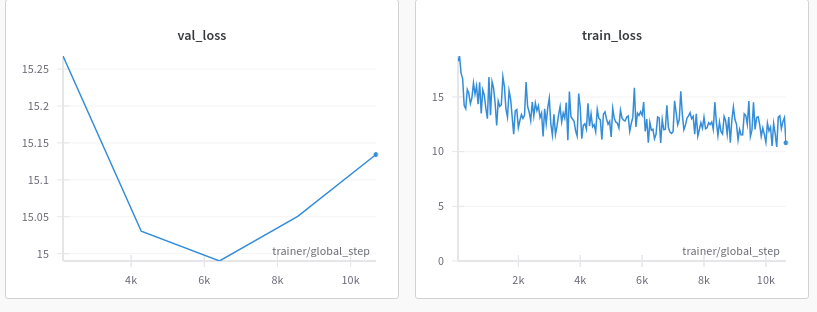

**Модель с применением лематизации**

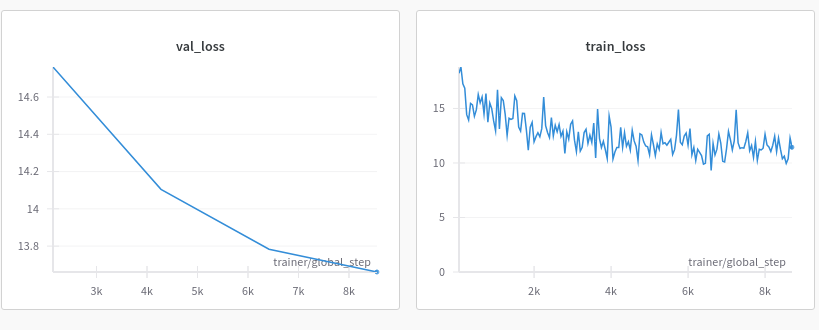

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/184.zip

--2023-12-18 10:21:09--  http://vectors.nlpl.eu/repository/20/184.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640196018 (611M) [application/zip]
Saving to: ‘184.zip’

184.zip             100%[===================>] 610.54M  17.5MB/s    in 36s     

2023-12-18 10:21:47 (16.8 MB/s) - ‘184.zip’ saved [640196018/640196018]



In [ ]:
!unzip 184.zip

Archive:  184.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [ ]:
embedding_matrix = []
words = set()

with open('/content/model.txt') as f:
    f.readline()
    for line in f:
        word, vec = line.split(' ', 1)
        word = word.split('_')[0]   # remove POS tag
        if word in words:   # keep only one embedding for words with different POS
            continue
        words.add(word)
        vec = torch.tensor([float(i) for i in re.findall('\S+', vec)])
        embedding_matrix.append(vec)

embedding_matrix = torch.stack(embedding_matrix)
word2idx = {word: idx for idx, word in enumerate(words)}

In [ ]:
class NewsDataset(Dataset):

    def __init__(self, target, texts, max_classes):
        self.max_classes = max_classes
        self.texts = texts
        self.y = self.target_ohe(target)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return (self.texts[idx], self.y[idx])

In [ ]:
CLASSES_NUM = len(idx2tag)

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, CLASSES_NUM)
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, CLASSES_NUM)
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, CLASSES_NUM)

In [ ]:
!pip install pymorphy2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 85.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def collate_fn(batch):

    texts, target = list(zip(*batch))

    eps = 0.001
    res = []
    for sentence in texts:
        encoded_sentence = torch.zeros(len(word2idx))
        for word in sentence.split():
            lemma = morph.parse(word)[0].normal_form
            idx = word2idx.get(lemma)
            if idx is None:
                continue
            encoded_sentence[idx] = 1
        encoded_sentence = encoded_sentence / (encoded_sentence.sum() + eps)
        res.append(encoded_sentence)

    return torch.stack(res), torch.stack(target)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64, num_workers=2, collate_fn=collate_fn)

In [ ]:
class RusvectoresClassifier(nn.Module):

    def __init__(self, embedding_dim, output_dim, embedding_matrix):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.embedding_matrix = embedding_matrix


    def forward(self, title):
        embedded = torch.matmul(title, self.embedding_matrix)
        return self.fc(embedded)

In [ ]:
seed_everything(SEED)

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model = RusvectoresClassifier(EMBEDDING_DIM, CLASSES_NUM, embedding_matrix.to(device))
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model, LR, criterion)

wandb_logger = WandbLogger(log_model='all', project='hw_4')
trainer = pl.Trainer(max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | RusvectoresClassifier | 476 K 
1 | criterion | CrossEntropyLoss      | 0     
----------------------------------------------------
476 K     Trainable params
0         Non-trainable params
476 K     Total params
1.906     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


##### Подбор порога по валидационной выборке и оценка на тесте




Добавил в get_predict collate_fn

In [ ]:
def get_predict(model, dataset, collate_fn=None):

    dataloader = DataLoader(dataset, shuffle=False, collate_fn=collate_fn)

    pred_probs = torch.empty(len(dataset), CLASSES_NUM)
    targets = torch.empty(len(dataset), CLASSES_NUM)

    model.eval()
    with torch.no_grad():
        for iter, (*text, target) in tqdm(enumerate(dataloader), total=len(dataset)):
            logit = model(*text)
            pred_probs[iter, :] = F.softmax(logit, dim=1).squeeze()
            targets[iter, :] = target

    assert pred_probs.shape[0] == dataset.__len__()

    return pred_probs, targets

In [ ]:
pred_prob, target = get_predict(model, val_dataset, collate_fn)

  0%|          | 0/43258 [00:00<?, ?it/s]

In [ ]:
TRESHOLD = optimaize_precision(pred_prob, target)
TRESHOLD

  0%|          | 0/100 [00:00<?, ?it/s]

0.1

In [ ]:
pred_prob, target = get_predict(model, test_dataset, collate_fn)

  0%|          | 0/21304 [00:00<?, ?it/s]

In [ ]:
y_pred = 1 * (pred_prob > 0.11)
precision(target, y_pred)

0.38779541850090027

### Трансформер

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

Выбор модели ruBert-base от команды SberDevices обусловлен несколькими причинами:

1) Модели семейства BERT основаны на энкодере трансформера и хорошо справляются с задачей классификации

2) ruBert обучался на данных на русском языке

3) ruBert-large мог бы не влезть в колаб и обучать пришлось бы долго

4) ruBert от SberDevices на большинстве задач показывает качество лучше, чем ruBert, разработанный DeepPavlov

__Ваш лог экспериментов:__

-
-
-

https://huggingface.co/pa-shk/hw_texts/tensorboard?params=timeseries#frame

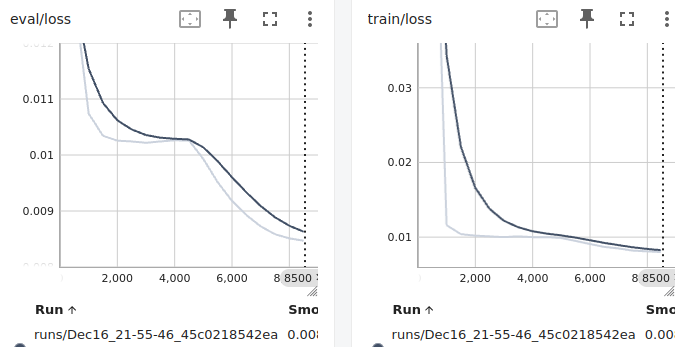


Код основан на материлах официальной документации HuggingFace, а также на этом [туториале](https://colab.research.google.com/drive/1aue7x525rKy6yYLqqt-5Ll96qjQvpqS7)

In [ ]:
!pip install transformers -q
!pip install datasets -q
!pip install accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
from datasets import DatasetDict, Dataset


train = {'text': df_train.title,
         'labels': df_train.target_tags}

val = {'text': df_val.title,
        'labels': df_val.target_tags}

test = {'text': df_test.title,
        'labels': df_test.target_tags}


dataset = DatasetDict({
    'train': Dataset.from_dict(train),
    'val': Dataset.from_dict(val),
    'test': Dataset.from_dict(test)})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 136875
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 43258
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 21304
    })
})

In [ ]:
CLASSES_NUM = len(idx2tag)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")

def preprocess_data(examples):
    text, labels = examples["text"], examples["labels"]
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=50)
    encoding["labels"] = torch.zeros(CLASSES_NUM)
    encoding["labels"][labels] = torch.ones(len(labels))
    return encoding

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("ai-forever/ruBert-base",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(idx2tag),
                                                           id2label=idx2tag)

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
encoded_dataset = dataset.map(preprocess_data, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/136875 [00:00<?, ? examples/s]

Map:   0%|          | 0/43258 [00:00<?, ? examples/s]

Map:   0%|          | 0/21304 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset.set_format("torch")
encoded_dataset = (encoded_dataset
                   .map(lambda x : {"float_labels": x["labels"].to(torch.float)}, remove_columns=["labels"])
                   .rename_column("float_labels", "labels"))

Map:   0%|          | 0/136875 [00:00<?, ? examples/s]

Map:   0%|          | 0/43258 [00:00<?, ? examples/s]

Map:   0%|          | 0/21304 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
batch_size = 16

args = TrainingArguments(
    output_dir = 'hw_texts',
    evaluation_strategy = "steps",
    save_strategy = "steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
)

In [ ]:
seed_everything(SEED)
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,0.072200,0.012870
1000,0.011600,0.010740
1500,0.010400,0.010343
2000,0.010200,0.010256
2500,0.010100,0.010242
3000,0.010000,0.010217
3500,0.010100,0.010242
4000,0.010000,0.010262
4500,0.010000,0.010259
5000,0.009900,0.009929


TrainOutput(global_step=8555, training_loss=0.01317197541825469, metrics={'train_runtime': 4918.6346, 'train_samples_per_second': 27.828, 'train_steps_per_second': 1.739, 'total_flos': 3566849673937500.0, 'train_loss': 0.01317197541825469, 'epoch': 1.0})

##### Подбор порога по валидационной выборке и оценка на тесте

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification


pipe = pipeline("text-classification",
                model="pa-shk/hw_texts",
                device=device,
                padding=True,
                truncation=True,
                max_length=50,
                top_k=None,
                batch_size=16)

config.json:   0%|          | 0.00/208k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/718M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset

dataset = Dataset.from_dict({'text': df_val.title})

pred_prob = []
for out in tqdm(pipe(KeyDataset(dataset, "text")), total=dataset.num_rows):
    pred = torch.empty(len(idx2tag))
    for cls in out:
        label, score = cls['label'], cls['score']
        idx = tag2idx[label]
        pred[idx] = score
    pred_prob.append(pred)

  0%|          | 0/43258 [00:00<?, ?it/s]

In [ ]:
pred_prob = torch.stack(pred_prob)

target = torch.zeros(df_val.shape[0], CLASSES_NUM)
for idx, tags in enumerate(df_test.target_tags):
  target[idx, tags] = torch.ones(len(tags))

In [ ]:
TRESHOLD = optimaize_precision(pred_prob, target)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
TRESHOLD

0.22

In [ ]:
dataset = Dataset.from_dict({'text': df_test.title})

pred_prob = []
for out in tqdm(pipe(KeyDataset(dataset, "text")), total=dataset.num_rows):
    pred = torch.empty(len(idx2tag))
    for cls in out:
        label, score = cls['label'], cls['score']
        idx = tag2idx[label]
        pred[idx] = score
    pred_prob.append(pred)

In [ ]:
pred_prob = torch.stack(pred_prob)

target = torch.zeros(df_test.shape[0], CLASSES_NUM)
for idx, tags in enumerate(df_test.target_tags):
  target[idx, tags] = torch.ones(len(tags))

In [ ]:
y_pred = 1 * (pred_prob > TRESHOLD)
precision(target, y_pred)

0.5195022821426392

Несмотря на эксперименты с разными архитектурами, безлайн пробить, к сожалению, не удалось. Мне кажется, это связано с особенностью задачи - количество классов очень большое и при этом некоторых из них очень малочисленны. Полагаю, правильнее было бы решать задачу через metric learning, а также, возможно, считать метрики отдельно для каждого класса (у меня BERT выдает почти для каждой новости максимальную вероятность тегу "россия", просто потому что это наиболее распространеный тег в тренировочных данных). Если потом использовать теги для пользовательской фильтрации новостей, то можно посчитать retrival метрики (recall@k, precision@k) для каждого класса.

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, title, vocab, vocab_size, max_title_len):

        self.vocab = {word: idx  for word, idx in vocab.items() if idx < vocab_size}
        self.X_title = self.create_text(title, max_title_len)


    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return self.X_title[idx, :]

In [ ]:
VOCAB_SIZE = 10000

In [ ]:
vk_dataset = NewsDataset(df_vk.title_clean.values,
                         vocabulary,
                         VOCAB_SIZE,
                         MAX_TITLE_LEN)

In [ ]:
vk_dataloader = DataLoader(vk_dataset,
                           shuffle=False,
                           batch_size=len(vk_dataset),
                           num_workers=2)

In [ ]:
model_baseline.eval()
with torch.no_grad():
    for text in (vk_dataloader):
        logit = model_baseline(text)
        pred_probs = F.softmax(logit, dim=1)

assert pred_probs.shape[0] == vk_dataset.__len__()

In [ ]:
TRESHOLD = 0.13

In [ ]:
(pred_probs > TRESHOLD).nonzero(as_tuple=False)

tensor([[    0,   514],
        [    1,   450],
        [    3,   514],
        ...,
        [19926,   514],
        [19926,   898],
        [19927,  1061]])

In [ ]:
res = [[] for _ in range(len(vk_dataset))]

In [ ]:
for sample, pred_index in (pred_probs > TRESHOLD).nonzero(as_tuple=False):
    res[sample].append(pred_index.item())

In [ ]:
df_vk['target_tags'] = np.array(res)
df_vk

<ipython-input-58-0cddaaed875e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_vk['target_tags'] = np.array(res)


,id,href,datetime,title,likes,comments,snippet,snippet_clean,title_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,#UNKN,в днр заявили о задержании диверсантов причаст...,[514]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,#UNKN,житель урала заминировал тц изза снятия сотов...,[450]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,#UNKN,в черном море нашли потерянный флот гитлера,[]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,#UNKN,в сша освободили задержанную российскую актрис...,"[514, 898, 1061]"
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,#UNKN,толкнувший скабееву депутат рады заявил о гроз...,"[514, 567]"
...,...,...,...,...,...,...,...,...,...,...
19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,#UNKN,политологи назвали губернаторов которым грозит...,"[589, 1061]"
19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,#UNKN,захарова рассказала какую книгу подписывал лав...,[1061]
19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,#UNKN,современные люди появились более 300 тысяч лет...,"[241, 1146]"
19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,#UNKN,в сша ребенок устроил стрельбу,"[514, 898]"


In [ ]:
drive.mount(r"/content/drive/")
WORKING_DIRECTORY = pathlib.PurePath(r"/content/drive/MyDrive/hw_3")
df_vk.to_csv(WORKING_DIRECTORY / 'vk.csv')

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

1. Автор модели пользователь под ником seara. Модель является затюненой версии модели rubert-tiny2, автор которой Давид Дале (cointegrated), на датасете собранным С. Сметаниным.
2. Модель небольшая, архитектура BERT, состоит из 3 слоев (под слоями, наверно, имеется в виду SA + функция активации). Описание архитектуры от автора rubert-tiny2: "маленький BERT (3 слоя, 45 мб весов, 12M параметров, из которых 9M - эмбеддинги)"
3. Модель тюнилась на на датасете, представляющим из себя коллекцию из датасетов Kaggle Russian News Dataset, Linis Crowd 2015, Linis Crowd 2016, RuReviews, RuSentiment. Модель адектватно использовать для классификации комментариев ВК, так как датасет содержит отзывы, оставленные в интернете, а также тексты новостей, поэтому у модели, наверное, получится строить хорошие эмбеддинги для новостной лексики, используемой в обсуждениях

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install transformers -q

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification


pipe = pipeline("text-classification",
                model="seara/rubert-tiny2-russian-sentiment",
                device=device,
                padding=True,
                truncation=True,
                batch_size=16)

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset


dataset = Dataset.from_dict({'text': df_comments.text,
                             'likes': df_comments.likes})

labels, scores = [], []
for out in tqdm(pipe(KeyDataset(dataset, "text")), total=dataset.num_rows):
    labels.append(out['label'])
    scores.append(out['score'])

  0%|          | 0/2612629 [00:00<?, ?it/s]

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
df_comments['sentiment_verdict'] = np.array(labels)
df_comments['sentiment_score'] = np.array(scores)

# <ваш код для сохранения данных>


# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает

In [ ]:
drive.mount(r"/content/drive/")

Mounted at /content/drive/


In [ ]:
WORKING_DIRECTORY = pathlib.PurePath(r"/content/drive/MyDrive/hw_3")
df_comments.to_csv(WORKING_DIRECTORY / 'comments.csv')

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [ ]:
drive.mount(r"/content/drive/")
WORKING_DIRECTORY = pathlib.PurePath(r"/content/drive/MyDrive/hw_3")

Mounted at /content/drive/


In [ ]:
df_comments = pd.read_csv(WORKING_DIRECTORY / 'comments.csv')
df_vk = pd.read_csv(WORKING_DIRECTORY / 'vk.csv')

In [ ]:
df_comments

,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
0,0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246
1,1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370
2,2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261
3,3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939
4,4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223
...,...,...,...,...,...,...,...,...
2612624,2704580,17991829.0,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0,neutral,0.649754
2612625,2704581,17992004.0,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936
2612626,2704582,17992058.0,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313
2612627,2704583,17992487.0,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0,neutral,0.873600


In [ ]:
df_vk

,Unnamed: 0,id,href,datetime,title,likes,comments,snippet,snippet_clean,title_clean,target_tags
0,0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,#UNKN,в днр заявили о задержании диверсантов причаст...,[514]
1,1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,#UNKN,житель урала заминировал тц изза снятия сотов...,[450]
2,2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,#UNKN,в черном море нашли потерянный флот гитлера,[]
3,3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,#UNKN,в сша освободили задержанную российскую актрис...,"[514, 898, 1061]"
4,4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,#UNKN,толкнувший скабееву депутат рады заявил о гроз...,"[514, 567]"
...,...,...,...,...,...,...,...,...,...,...,...
19923,19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,#UNKN,политологи назвали губернаторов которым грозит...,"[589, 1061]"
19924,19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,#UNKN,захарова рассказала какую книгу подписывал лав...,[1061]
19925,19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,#UNKN,современные люди появились более 300 тысяч лет...,"[241, 1146]"
19926,19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,#UNKN,в сша ребенок устроил стрельбу,"[514, 898]"


In [ ]:
comment_counts = df_comments.sentiment_verdict.value_counts()
comment_counts

neutral     1826749
negative     597766
positive     188114
Name: sentiment_verdict, dtype: int64

In [ ]:
'Positive shape:', comment_counts['positive'] / comment_counts.sum()

('Positive shape:', 0.07200180354730809)

In [ ]:
'Negative shape:', comment_counts['negative'] / comment_counts.sum()

('Negative shape:', 0.22879865453533585)

In [ ]:
positive = df_comments[df_comments.sentiment_verdict == 'positive']
positive.sort_values(by=['sentiment_score'], ascending=False).head(10)

,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score
493792,508965,23095070.0,23094261.0,2018-11-17 11:21:56,"Отлично, молодец!Поздравляю!✨💫🌟💥",0.0,positive,0.996725
1379447,1424111,21323499.0,21322970.0,2018-06-20 18:54:40,Отлично! Просто отлично! Молодцы! Поздравляю о...,3.0,positive,0.996674
2352264,2434524,18718201.0,18718179.0,2017-11-30 13:22:42,"отлично,молодцы!!!👍 респект",3.0,positive,0.996605
2057938,2128990,19643844.0,19640879.0,2018-02-16 08:33:19,Отлично! \nПоздравляем!!!,1.0,positive,0.996536
2074701,2146325,19591344.0,19588477.0,2018-02-12 08:25:08,"Отлично,я рад.",0.0,positive,0.996462
236794,243929,23585686.0,23584622.0,2018-12-29 11:48:39,"Отлично,молодцы",2.0,positive,0.996461
1300899,1342337,21515168.0,21514312.0,2018-07-06 15:22:04,"Отлично,люблю ездить в Эмираты",0.0,positive,0.996450
288287,296711,23487341.0,23487299.0,2018-12-20 12:34:50,Отлично! Здоровья всем желаю!,8.0,positive,0.996444
411428,423821,23248899.0,23242108.0,2018-11-30 07:31:37,Я очень счастлива! Поздравляю!,0.0,positive,0.996431
1681663,1737559,20633834.0,20633609.0,2018-04-25 10:13:42,"Отлично, просто отлично!",0.0,positive,0.996418


__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [ ]:
merged_df = pd.merge(df_comments[['sentiment_verdict', 'sentiment_score', 'post_id']],
                     df_vk.rename(columns={'id': 'post_id'}),
                     how="left",
                     on="post_id").rename(columns={'post_id': 'id'})

In [ ]:
merged_df['positive_comments'] = merged_df.sentiment_verdict == 'positive'
merged_df['negative_comments'] = merged_df.sentiment_verdict == 'negative'

In [ ]:
df_vk = pd.merge(df_vk,
                 pd.DataFrame(merged_df.groupby(['id'])['positive_comments'].sum()).reset_index())

df_vk = pd.merge(df_vk,
                 pd.DataFrame(merged_df.groupby(['id'])['negative_comments'].sum()).reset_index())

df_vk

,Unnamed: 0,id,href,datetime,title,likes,comments,snippet,snippet_clean,title_clean,target_tags,positive_comments,negative_comments
0,0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,#UNKN,в днр заявили о задержании диверсантов причаст...,[514],2,10
1,1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,#UNKN,житель урала заминировал тц изза снятия сотов...,[450],3,11
2,2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,#UNKN,в черном море нашли потерянный флот гитлера,[],3,4
3,3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,#UNKN,в сша освободили задержанную российскую актрис...,"[514, 898, 1061]",2,10
4,4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,#UNKN,толкнувший скабееву депутат рады заявил о гроз...,"[514, 567]",10,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19922,19923,17976905,/politics/20170929/1505812885.html,2017-09-29 03:51:03,"Политологи назвали губернаторов, которым грози...",141,114,NaN,#UNKN,политологи назвали губернаторов которым грозит...,"[589, 1061]",4,31
19923,19924,17976766,/politics/20170929/1505809314.html,2017-09-29 03:20:41,"Захарова рассказала, какую книгу подписывал Ла...",140,50,NaN,#UNKN,захарова рассказала какую книгу подписывал лав...,[1061],8,11
19924,19925,17976601,/science/20170928/1505787196.html,2017-09-29 02:55:49,Современные люди появились более 300 тысяч лет...,202,69,NaN,#UNKN,современные люди появились более 300 тысяч лет...,"[241, 1146]",0,11
19925,19926,17976198,/world/20170929/1505810992.html,2017-09-29 02:00:09,В США ребенок устроил стрельбу,138,51,NaN,#UNKN,в сша ребенок устроил стрельбу,"[514, 898]",1,10


__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

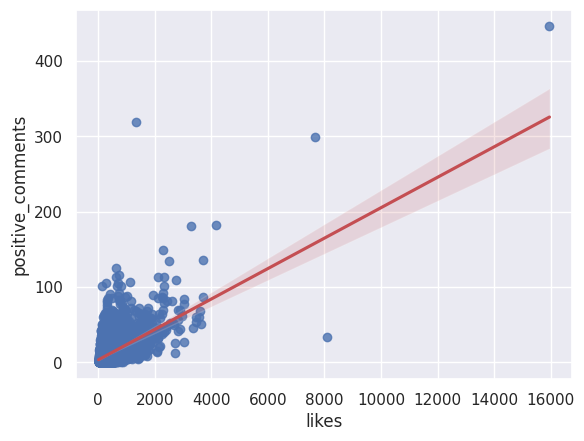

In [ ]:
ax = sns.regplot(data=df_vk,
                 x='likes',
                 y='positive_comments',
                 line_kws=dict(color="r"))

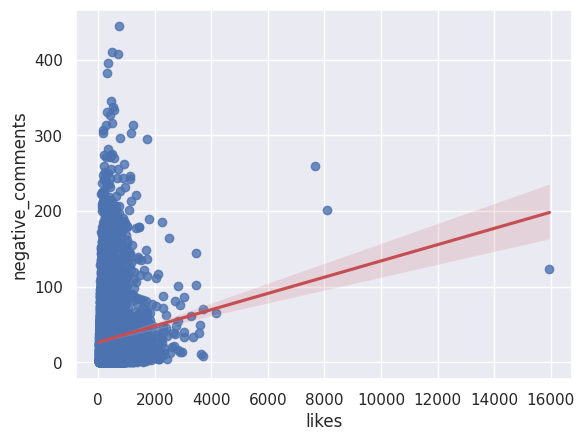

In [ ]:
ax = sns.regplot(data=df_vk,
                 x='likes',
                 y='negative_comments',
                 line_kws=dict(color="r"))

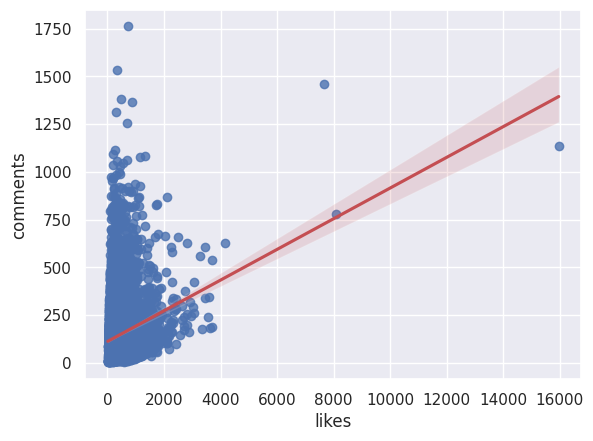

In [ ]:
ax = sns.regplot(data=df_vk,
                 x='likes',
                 y='comments',
                 line_kws=dict(color="r"))

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [ ]:
def get_score(positive_comments, comments):

    a = 1 + positive_comments
    b = 1 + comments - positive_comments

    return a / (a + b) - 1.65 * np.sqrt(a * b / (np.square(a + b) * (a + b + 1)))

In [ ]:
df_vk['positive_score'] = df_vk.apply(
    lambda x: get_score(x.positive_comments, x.comments), axis=1
    )

df_vk[['title', 'positive_score']].sort_values(
    by=['positive_score'], ascending=False).head(10)

,title,positive_score
6650,Сборная России выиграла командный турнир на че...,0.530298
6619,Россиянки заняли третье место в ските среди юн...,0.502010
12528,"""Ак Барс"" стал трехкратным обладателем Кубка Г...",0.446092
2880,В Балашихе спасли провалившегося под лед ребенка,0.437839
19212,Фигуристы Тарасова и Морозов победили в соревн...,0.437839
4967,Сборная России вернулась в Москву после победы...,0.426719
13793,В Финляндии появился отель на лыжах,0.426576
7571,"Россиянин Иван Бессонов победил в конкурсе ""кл...",0.421178
14019,"Миленина выиграла биатлонную гонку на 12,5 км,...",0.419815
13929,Вопреки всему: россияне стали вторыми на Парал...,0.417084


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

Для выделения положительных категорий новостей можно посмотреть на суммарное количество комментариев для каждой категории и применить формулу из предыдущего пункта

In [ ]:
df_vk.target_tags = df_vk.target_tags.apply(
    lambda x: [int(i) for i in re.findall('\d+', x)]
    )

In [ ]:
comments_tags = {}

In [ ]:
for tags, positive_comments, comments in zip(df_vk.target_tags,
                                             df_vk.positive_comments,
                                             df_vk.comments):
    for tag in tags:
        tag = int(tag)
        if tag in comments_tags:
            comments_counter = comments_tags[tag]
            comments_counter['positive'] += positive_comments
            comments_counter['all'] += comments
        else:
            comments_counter = {'positive': positive_comments,
                                'all': comments}
            comments_tags[tag] = comments_counter

In [ ]:
most_positive = sorted(comments_tags.items(),
                       key=lambda x: get_score(x[1]['positive'], x[1]['all']),
                       reverse=True)[:5]

In [ ]:
most_positive

[(38, {'positive': 42, 'all': 78}),
 (1105, {'positive': 426, 'all': 1062}),
 (1567, {'positive': 311, 'all': 897}),
 (445, {'positive': 49, 'all': 129}),
 (25, {'positive': 44, 'all': 120})]

In [ ]:
for idx, _ in most_positive:
    print(idx2tag[idx])

крымский мост
хоккей с мячом
татарстан
яндекс
стивен сигал


__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
negative_comments = df_comments[df_comments.sentiment_verdict == 'negative']

In [ ]:
negative_comments = pd.merge(negative_comments,
                             df_vk[['id', 'comments']].rename(columns={'id': 'post_id'}),
                             on='post_id')

In [ ]:
negative_comments

,Unnamed: 0,id,post_id,datetime,text,likes,sentiment_verdict,sentiment_score,comments
0,14,24006399.0,24006362.0,2019-02-01 23:26:52,"[id109937745|Илья], привет жителям Окраины! Ка...",1.0,negative,0.791067,28
1,16,24006404.0,24006362.0,2019-02-01 23:28:27,"[id4710641|Евгений], а с чего это бюджетные де...",1.0,negative,0.579184,28
2,17,24006405.0,24006362.0,2019-02-01 23:28:38,"[id98684712|Андрей], ну да, только особо ничег...",1.0,negative,0.899649,28
3,26,24006419.0,24006362.0,2019-02-01 23:32:24,"[id281789680|Едыге], одного из раненых в очко",1.0,negative,0.482806,28
4,33,24006443.0,24006362.0,2019-02-01 23:40:05,Для путина и его шайки воров восстание русског...,0.0,negative,0.899264,28
...,...,...,...,...,...,...,...,...,...
597761,2704576,17990119.0,17976037.0,2017-09-30 06:27:10,"[id142882974|Сергей], амеры как и Россия воююи...",0.0,negative,0.819313,241
597762,2704579,17991797.0,17976037.0,2017-09-30 10:21:42,"[id415883695|Евгений], конечно за свои шкурные...",0.0,negative,0.547738,241
597763,2704581,17992004.0,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936,241
597764,2704582,17992058.0,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313,241


In [ ]:
import scipy.stats

x = np.array(negative_comments['comments'])
y = np.array(negative_comments['sentiment_score'])
scipy.stats.pearsonr(x, y)

PearsonRResult(statistic=0.028265905426624376, pvalue=6.495704591284883e-106)

Между количеством коментариев под постом и вероятностью что комментарий негативный есть очень слабая положительная корреляция, которая является статический значимой, т.к pvalue < 0.05